# Visualizing the Quickdraw data subset

This is an example of writing an embeddings file to disk so that you can load it in TensorBoard

This notebook has used pixel values as the vector embedding. I encourage you to export a vector embedding out of your CNN trained on this dataset.

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import numpy as np
import os

from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

print(tf.__version__)

LOG_DIR = 'quickdraw3'
NAME_TO_VISUALISE_VARIABLE = "quickdraw_embedding"

# number of records to show in the embedding 
TO_EMBED_COUNT = 200


sprites_path =  os.path.join(LOG_DIR,'quickdraw.png')
metadata_path =  os.path.join(LOG_DIR,'metadata.tsv')
print(metadata_path)


1.2.1
quickdraw3/metadata.tsv


## Setting up and loading the Quickdraw data

In [75]:
num_examples_per_class = 5000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana','bandage','barn','baseball bat','baseball',
           'basket','basketball','bathtub','beach','bear','beard','bed','bee','belt','bicycle','binoculars','birthday cake','blueberry',
           'book','boomerang','bottlecap','bowtie','bracelet','brain','bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']

In [90]:
x_data = np.load("./x_data_40_classes_5k.npy")

x_data.shape

(200000, 784)

### Make labels 

In [91]:
labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_data.shape

(200000,)

In [92]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [93]:
x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [94]:
num_classes = 40
number_of_records = len(y_data)
test_fraction = 0.1

print(int(number_of_records*test_fraction))

#making a train / test split
test_split = int(number_of_records*(1-test_fraction))

x_train, y_train = x_data[0:test_split], y_data[0:test_split]
x_test, y_test = x_data[test_split:], y_data[test_split:]

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

20000
(180000, 784)
(180000,)
(20000, 784)
(20000,)


## Setup for Tensorboard saving

In [95]:
# create embeddings

embedding_var = tf.Variable(x_test, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [83]:
#Embeddings projector - this saves everything protobuf text file

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Where you find the metadata
embedding.metadata_path = 'metadata.tsv' #contrary to TF current docs dont put dir in path

# Location for the sprite image
embedding.sprite.image_path = 'quickdraw.png' #contrary to TF current docs dont put dir in path
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)


### Running the session as interactive session and writing the checkpoint

In [84]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'quickdraw3/model.ckpt-1'

## Creating the sprites and the meta data

In [85]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix(quickdraws):
    """Reshapes normal to (None,28,28)"""
    return np.reshape(quickdraws,(-1,28,28))

def invert_grayscale(quickdraws):
    """ Makes black white, and white black """
    return 1-quickdraws

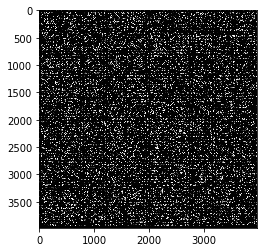

In [86]:
to_visualise = x_test
to_visualise = vector_to_matrix(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

# print out the sprite to see what it looks like
plt.imsave(sprites_path,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

In [102]:
# write the labels 
with open(metadata_path,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(y_test):
        f.write("%d\t%s\n" % (index,classes[label]))

## Runnning TensorBoard

you could also run this from the command line directly

remember after you run this cell you need to open a browser window and goto http://localhost:6006/#embeddings



In [100]:
!tensorboard --logdir=quickdraw3

Starting TensorBoard b'54' at http://Sams-MacBook-Pro.local:6006
(Press CTRL+C to quit)
^C
